In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.spatial.distance import jensenshannon
from scipy.stats.distributions import gamma
import pyBigWig

from skfda import FDataGrid
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import BSplineBasis
from skfda.exploratory.visualization import FPCAPlot

from loadData import load_profile, smooth

In [2]:
def load_transcript():
    tss = pd.read_csv(
        'data/ref/GSE49026_S-TSS.txt',
        delimiter='\t',
        usecols=['chr', 'coordinate', 'ORF']
    )
    tss.columns = ['chr', 'start', 'ORF']
    pas = pd.read_csv(
        'data/ref/GSE49026_S-PAS.txt',
        delimiter='\t',
        usecols=['coordinate', 'ORF']
    )
    pas.columns = ['end', 'ORF']
    combined_df = pd.merge(left=tss, right=pas, left_on='ORF', right_on='ORF')
    combined_df['size'] = np.abs(combined_df['start'] - combined_df['end'])
    return combined_df

In [15]:
wt_ocampo_a = load_profile('data/mat_large_genes/Ocampo_WT_A/')
drop_list = ['cluster', 'ORF']
wt_ocampo_data = wt_ocampo_a.drop(drop_list, axis=1).to_numpy()

In [16]:
gene_pos = load_transcript()

In [17]:
pol2_path = 'data/seq/L5_18.BT2.SacCer3.RPM.Norm.bw'
pol2_bw = pyBigWig.open(pol2_path)
pol2_data = {'ORF': [], 'Pol2': []}

for i, gp in gene_pos.iterrows():
    pol2_data['ORF'].append(gp['ORF'])
    if gp['start'] <= gp['end']:
        pol2_data['Pol2'].append(
            np.nanmean(pol2_bw.values(gp['chr'], int(gp['start']), int(gp['start']) + wt_ocampo_data.shape[1]))
        )
    else:
        pol2_data['Pol2'].append(
            np.nanmean(pol2_bw.values(gp['chr'], int(gp['start']) - wt_ocampo_data.shape[1], int(gp['start'])))
        )

In [18]:
pol2_data = pd.DataFrame(pol2_data)
wt_ocampo_a = pd.merge(wt_ocampo_a, pol2_data, left_on='ORF', right_on='ORF')
drop_list.append('Pol2')

In [25]:
wt_ocampo_a = wt_ocampo_a.sort_values(by='Pol2', ascending=False)
wt_ocampo_a['Pol2']

1331    52.227369
3011    39.751724
2152    38.544288
1924    36.016811
1533    34.275620
          ...    
1415     0.176978
3411     0.166661
1366     0.154063
1728     0.130308
286      0.109525
Name: Pol2, Length: 3579, dtype: float64

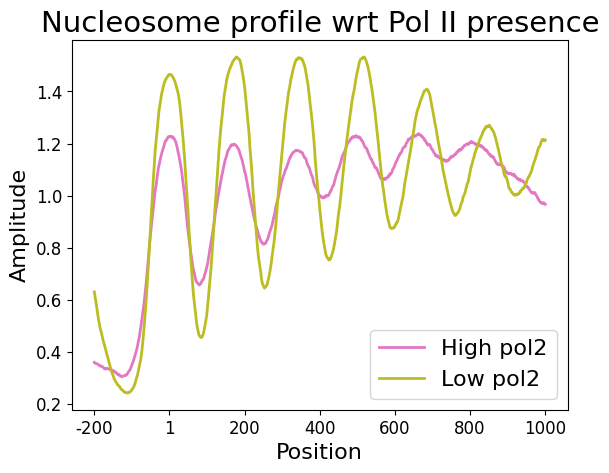

In [29]:
extreme_ratio = .15
plt.plot(
    np.mean(wt_ocampo_a.iloc[:int(wt_ocampo_data.shape[1] * extreme_ratio)].drop(
        drop_list, axis=1).to_numpy(), axis=0),
    color='tab:pink',
    label='High pol2',
    lw=2
)
plt.plot(
    np.mean(wt_ocampo_a.iloc[-int(wt_ocampo_data.shape[1] * extreme_ratio):].drop(
        drop_list, axis=1).to_numpy(), axis=0),
    color='tab:olive',
    label='Low pol2',
    lw=2
)
plt.legend(fontsize=16)
plt.xlabel('Position', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.xticks(np.arange(0, 1201, 200), [-200, +1, 200, 400, 600, 800, 1000], fontsize=12)
plt.yticks(fontsize=12)
plt.title('Nucleosome profile wrt Pol II presence', fontsize=21)
plt.show()